## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [4]:
###Check the data of the csv file
from os.path import join
import pandas as pd
import numpy as np
dirname = 'data'
data = pd.read_csv(join(dirname, 'gt.csv'))
points = data[data.columns[1:]]
points.values.dtype

dtype('int64')

In [5]:
### Useful routines for preparing data
#from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here

    data = pd.read_csv(join(dirname, 'gt.csv'))
    
    #No. of records
    N = data.shape[0]
    
    #Convert points data into numpy array after stripping the first column
    points_org = np.array(data[data.columns[1:]].values, dtype=np.float32)
    
    # initialize the returning points and imgs variables - both numpy arrays
    points = np.zeros_like(points_org, dtype=np.float32)
    imgs = np.zeros((N,100,100,3))

    # loop through all the images and points and preprocess them
    for i in range(N):
        img = imread(join(dirname,'images',data.filename[i]))
        w = img.shape[1]
        h = img.shape[0]
        points[i,:] = (points_org[1,:] / np.tile([w,h], 14)) - 0.5
        img = resize(img, (100,100,3))
        imgs[i,:,:,:] = img
    
    return imgs, points
    

imgs, points = load_imgs_and_keypoints()

/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([-0.24074075, -0.25308642, -0.05555556, -0.2777778 ,  0.2037037 ,
       -0.2654321 ,  0.48765433, -0.19135803, -0.21604939, -0.16666667,
       -0.08024691, -0.17901234, -0.00617284, -0.15432099,  0.22839506,
       -0.12962963,  0.33950618, -0.12962963,  0.46296296, -0.09259259,
        0.0308642 ,  0.06790123, -0.11728395,  0.25308642,  0.05555556,
        0.3148148 ,  0.24074075,  0.30246913], dtype=float32)

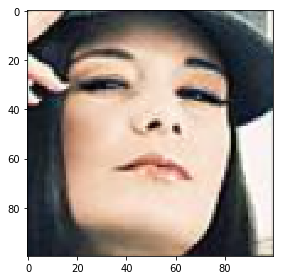

In [6]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[8])
points[8]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

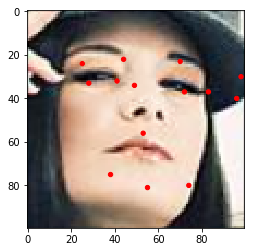

In [7]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image    
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(img)
    points_int = np.clip(np.array((points+0.5)*100, dtype=np.int32), 0, 99)
    for i in range(14):
        c = Circle((points_int[2*i], points_int[2*i+1]), radius=1, color='red')
        ax.add_patch(c)
    
visualize_points(imgs[8], points[8])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [8]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

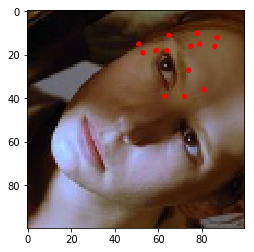

In [9]:
def flip_img(img, points):
    # Write your code for flipping here
    f_img = img[:,::-1,:]
    f_points = np.copy(points)
    for i in range(14):
        f_points[2*i] = -points[2*i]
    return f_img, f_points

f_img, f_points = flip_img(imgs[2], points[2])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [10]:
# Write your code here
N = imgs_train.shape[0]
aug_imgs_train = np.zeros((2*N, 100, 100, 3))
aug_points_train = np.zeros((2*N, 28))
for i in range(N):
    aug_imgs_train[2*i] = imgs_train[i]
    aug_points_train[2*i] = points_train[i]
    f_img, f_points = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train[2*i+1] = f_img
    aug_points_train[2*i+1] = f_points

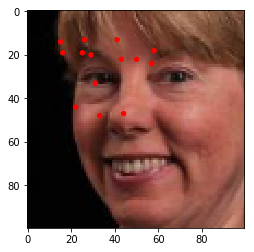

In [11]:
visualize_points(aug_imgs_train[60], aug_points_train[60])

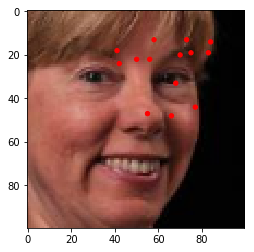

In [12]:
visualize_points(aug_imgs_train[61], aug_points_train[61])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [13]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
# Define here your model

# First set of conv layers with max pooling at the end
model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu', input_shape=(100,100,3)))
model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second set
model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Third set
model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fourth set
model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten it now
model.add(Flatten())

# 1st set of dense with droputs
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))

# 2nd set
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

# Final dense that outputs the 28 size vector
model.add(Dense(units=28, activation=None))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 128)       73856     
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [37]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(aug_imgs_train, aug_points_train, batch_size=64, shuffle=True, epochs=3)
#preds = model.evaluate(imgs_val, points_val)

Epoch 1/3
10800/10800 [==============================] - 668s 62ms/step - loss: 14370393.8030
Epoch 2/3
10800/10800 [==============================] - 6121s 567ms/step - loss: 586.5421
Epoch 3/3
10800/10800 [==============================] - 520s 48ms/step - loss: 0.1099


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

Image shape
(100, 100, 3)
Image shape that need to send to predict engine
(1, 100, 100, 3)
Shape of predicted points
(1, 28)
Shape of predicted points that visualizer needs
(28,)
Ground Truth vs predicted result


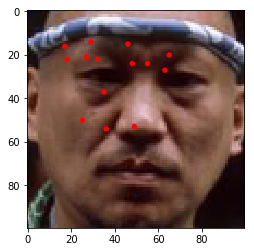

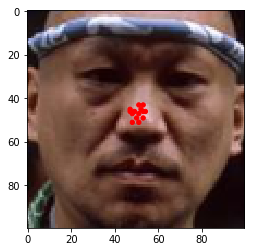

In [38]:
# Example of output
i = 3
# Need to send proper dimension (i.e. 4) to predict engine
print ('Image shape')
print(imgs_val[i].shape)
print ('Image shape that need to send to predict engine')
print(imgs_val[i:i+1].shape)

pred_points = model.predict(imgs_val[i:i+1])

print ('Shape of predicted points')
print(pred_points.shape)
print ('Shape of predicted points that visualizer needs')
print(points_val[i].shape)

# Need to send proper dimension (i.e. 3) to visualizer
print ('Ground Truth vs predicted result')
visualize_points(imgs_val[i], points_val[i])
visualize_points(imgs_val[i], pred_points[0])
#print((pred_points+0.5)*100)

In [36]:
print((pred_points+0.5)*100)

[[48.892662 50.260193 52.537346 49.396168 51.61542  49.980515 50.613426
  49.336468 48.809284 50.234444 50.298603 50.09495  52.43439  51.030804
  51.234776 51.239002 50.088387 51.02117  49.887688 50.252808 49.442173
  52.49675  48.66819  50.89285  50.214897 51.569904 50.28352  49.17036 ]]
